<a href="https://colab.research.google.com/github/alexkzw/classifying_handwritten_digits/blob/main/AIML425A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import jax
import jax.numpy as jnp
from jax import random, jit, grad
from functools import partial

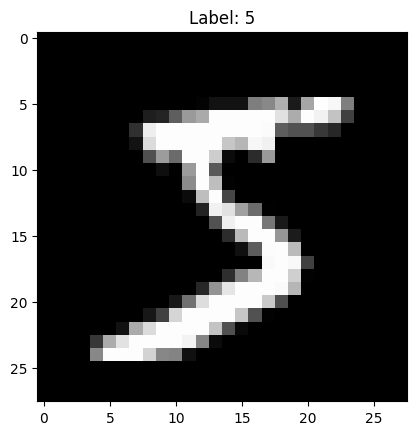

In [89]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Display the first image in the training set
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

In [90]:
# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [91]:
# Function to rotate images
def rotate_images(images):
    num_images = images.shape[0]
    # Initialise array filled with zeroes
    rotated_images = np.zeros_like(images)
    #Initialise an integer type 1D array filled with zeroes
    rotated_labels = np.zeros(num_images, dtype=int)

    for i in range(num_images):
        if i % 3 == 0:
            # Rotate image 90 degrees counterclockwise
            rotated_images[i] = np.rot90(images[i], k=1)
            rotated_labels[i] = 1  # Left
        elif i % 3 == 1:
            # Rotate image 90 degress clockwise
            rotated_images[i] = np.rot90(images[i], k=-1)
            rotated_labels[i] = 2  # Right
        else:
            # No rotation
            rotated_images[i] = images[i]
            rotated_labels[i] = 0

    return rotated_images, rotated_labels

In [92]:
# Rotate training and test images
train_images_rotated, train_labels_rotated = rotate_images(train_images)
test_images_rotated, test_labels_rotated = rotate_images(test_images)

Training Set Distribution:
Label 0: Count = 20000, Proportion = 0.33
Label 1: Count = 20000, Proportion = 0.33
Label 2: Count = 20000, Proportion = 0.33

Test Set Distribution:
Label 0: Count = 3333, Proportion = 0.33
Label 1: Count = 3334, Proportion = 0.33
Label 2: Count = 3333, Proportion = 0.33


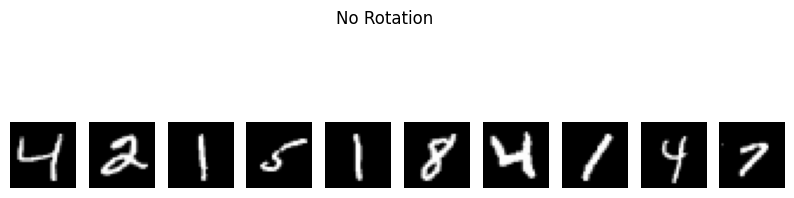

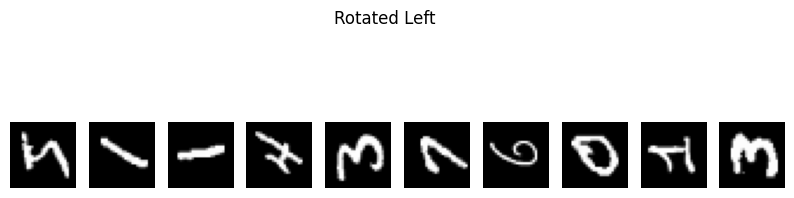

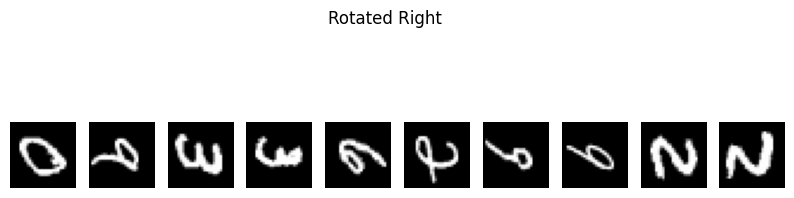

In [93]:
# confirm that 1/3 of the images are rotated left, rotated right, and no rotation
def check_distribution(labels):
    counts = np.bincount(labels)
    total = len(labels)

    for label, count in enumerate(counts):
        proportion = count / total
        print(f"Label {label}: Count = {count}, Proportion = {proportion:.2f}")

print("Training Set Distribution:")
check_distribution(train_labels_rotated)

print("\nTest Set Distribution:")
check_distribution(test_labels_rotated)

#Visualise a few images from each category
def visualise_samples(images, labels, label, title):
    plt.figure(figsize=(10, 3))
    plt.suptitle(title)
    indices = np.where(labels == label)[0][:10]
    for i, idx in enumerate(indices):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
    plt.show()

visualise_samples(train_images_rotated, train_labels_rotated, 0, "No Rotation")
visualise_samples(train_images_rotated, train_labels_rotated, 1, "Rotated Left")
visualise_samples(train_images_rotated, train_labels_rotated, 2, "Rotated Right")

In [94]:
# Split rotated training data into training and validation sets
def split_data(x, target, train_ratio=0.85):
    total_samples = x.shape[0]
    train_end = int(train_ratio * total_samples)

    x_train, y_train = x[:train_end], target[:train_end]
    x_val, y_val = x[train_end:], target[train_end:]

    return (x_train, y_train), (x_val, y_val)

(train_images_rotated, train_labels_rotated), (val_images_rotated, val_labels_rotated) = split_data(train_images_rotated, train_labels_rotated)

In [95]:
# Flatten rotated images from 28x28 to 784 dimensions (one-dimensional vectors)
# Convert to floating-point for efficient computation during gradient descent and backpropagation
train_images_flat = train_images_rotated.reshape(train_images_rotated.shape[0], -1).astype(jnp.float32)
val_images_flat = val_images_rotated.reshape(val_images_rotated.shape[0], -1).astype(jnp.float32)
test_images_flat = test_images_rotated.reshape(test_images_rotated.shape[0], -1).astype(jnp.float32)

In [96]:
# Just-in-time compilation for faster execution
@jit
def fcnn(params, x):
    # iterate over all layers except the output layer
    for layer in params[:-1]:
        x = jax.nn.relu(jnp.dot(x, layer[0]) + layer[1])
    layer = params[-1]
    # only linear transformation is applied to the output layer (no activation function)
    return jnp.dot(x, layer[0]) + layer[1]

# Initialize weights and biases of the neural network
def init_fcnn(dims, rng):
    params = []
    for i in range(1, dims.shape[0]):
        rng, key = random.split(rng)
        # generate random values from a normal distribution
        # specify shape of weight matrix connecting input neurons to output neurons
        w = random.normal(key, (dims[i-1], dims[i]))
        # scales weight using He initialisation
        w = w * jnp.sqrt(2 / dims[i-1])
        # initialise bias vector for the current layer with zeroes
        b = jnp.zeros((dims[i],))
        params.append([w, b])
    return params, rng

@partial(jit, static_argnums=(1,))
#phi - network parameters
#nn - neural network function
#input - input data
#target - target labels
def loss(phi, nn, input, target):
    output = nn(phi, input)
    the_loss = -jnp.mean(jax.nn.log_softmax(output) * jax.nn.one_hot(target, num_classes=3))
    aux = the_loss
    return the_loss, aux

@partial(jit, static_argnums=(1,))
def compute_accuracy(phi, nn, input, target):
    # obtain predicted class label by selecting index of highest value
    predictions = jnp.argmax(nn(phi, input), axis=1)
    # calculate accuracy by comparing predicted labels to target labels
    accuracy = jnp.mean(predictions == target)
    return accuracy

# Manually implement SGD update rule
def sgd_update(params, grads, learning_rate):
    new_params = []
    # loop over current parameters and their corresponding gradients
    for (w, b), (dw, db) in zip(params, grads):
        # update weights and biases using the gradient and learning rate
        new_w = w - learning_rate * dw
        new_b = b - learning_rate * db
        new_params.append([new_w, new_b])
    return new_params

def training(x_train, y_train, x_val, y_val, init_phi, nn, epochs, batch_size, learning_rate):
    # obtain number of training and validation samples
    num_train = x_train.shape[0]
    num_val = x_val.shape[0]
    # calculate number of batches per epoch
    batch_num = num_train // batch_size

    # initialise list to store training loss, training acc and validation acc
    lossline_train = []
    acc_train = []
    acc_val = []
    # set initial parameters for training
    phi = init_phi
    for epoch in range(epochs):
        for i in range(batch_num):
            x_batch = x_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]
            # for each batch in each epoch, compute gradients of loss function
            grads, aux = grad(loss, argnums=0, has_aux=True)(phi, nn, x_batch, y_batch)
            # update parameters using SGD update rule
            phi = sgd_update(phi, grads, learning_rate)

        # compute training loss for the entire training set
        train_loss, _ = loss(phi, nn, x_train, y_train)
        # compute training accuracy for the entire training set
        train_acc = compute_accuracy(phi, nn, x_train, y_train)
        # compute validation accuracy for the entire validation set
        val_acc = compute_accuracy(phi, nn, x_val, y_val)

        lossline_train.append(train_loss)
        acc_train.append(train_acc)
        acc_val.append(val_acc)

        # print training and validation metrics for the current epoch
        print(f"Epoch {epoch + 1}, Loss: {train_loss}, Train Accuracy: {train_acc}, Val Accuracy: {val_acc}")

    return phi, lossline_train, acc_train, acc_val

In [97]:
rng = random.PRNGKey(0)
# input layer with 784 neurons
# first hidden layer with 128 neurons
# second hidden layer with 64 neurons
# output layer corresponds to our three classes
layer_dims = jnp.array([784, 128, 64, 3])
params, rng = init_fcnn(layer_dims, rng)

epochs = 10
batch_size = 32
learning_rate = 0.01

params, lossline_train, acc_train, acc_val = training(train_images_flat, train_labels_rotated, val_images_flat, val_labels_rotated, params, fcnn, epochs, batch_size, learning_rate)

Epoch 1, Loss: 0.09412620216608047, Train Accuracy: 0.9169999957084656, Val Accuracy: 0.9271111488342285
Epoch 2, Loss: 0.057865630835294724, Train Accuracy: 0.9497451186180115, Val Accuracy: 0.9568889141082764
Epoch 3, Loss: 0.04163554310798645, Train Accuracy: 0.9641568660736084, Val Accuracy: 0.968999981880188
Epoch 4, Loss: 0.03227900713682175, Train Accuracy: 0.97292160987854, Val Accuracy: 0.9771111011505127
Epoch 5, Loss: 0.026226116344332695, Train Accuracy: 0.9787451028823853, Val Accuracy: 0.9806666970252991
Epoch 6, Loss: 0.022028310224413872, Train Accuracy: 0.9820588231086731, Val Accuracy: 0.9841111302375793
Epoch 7, Loss: 0.018950819969177246, Train Accuracy: 0.9848235249519348, Val Accuracy: 0.9865555763244629
Epoch 8, Loss: 0.01661355420947075, Train Accuracy: 0.9869216084480286, Val Accuracy: 0.987666666507721
Epoch 9, Loss: 0.014775576069951057, Train Accuracy: 0.9883333444595337, Val Accuracy: 0.9892222285270691
Epoch 10, Loss: 0.013291372917592525, Train Accuracy: 

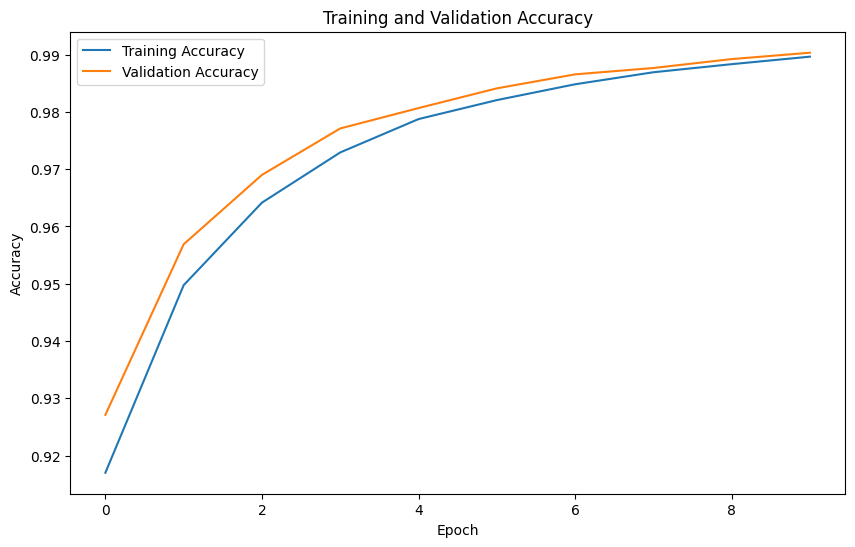

Test accuracy: 0.9891


In [98]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), acc_train, label='Training Accuracy')
plt.plot(range(epochs), acc_val, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate the model on test data
test_accuracy = compute_accuracy(params, fcnn, test_images_flat, test_labels_rotated)
print(f'Test accuracy: {test_accuracy:.4f}')